In [14]:
pip install datasets pillow matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [15]:
from datasets import load_dataset

ds = load_dataset("shiwk24/MathCanvas-Imagen", "code_derived_captions", split = "train", streaming = True)


Resolving data files:   0%|          | 0/337 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/254 [00:00<?, ?it/s]

In [16]:
from itertools import islice
from datasets import Dataset 

data = list(islice(ds,500))
subset_dataset = Dataset.from_list(data)

In [17]:
subset_dataset.save_to_disk("mathcanvas_subset_500")


Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

In [18]:
from datasets import load_from_disk
dataset = load_from_disk("mathcanvas_subset_500")
print("loaded")


loaded


In [19]:
print(dataset)
# dataset["train"].features



Dataset({
    features: ['id', 'code', 'caption', 'image'],
    num_rows: 500
})


In [20]:
INSTRUCTION = (
    "Analyze the given mathematical image. "
    "Describe the mathematical structure precisely. "
    "Only describe what is visible in the image. "
    "Use formal mathematical language."
)

In [21]:
def process_images(img):
    img = img. convert("RGB")
    img = img.resize((336,336))
    return img


def process_captions(caption):
    caption = caption.strip()
    return caption

def buildSample(sample):
    return {
        "image": process_images(sample["image"]),
        "instruction":INSTRUCTION,
        "response" : process_captions(sample["caption"])
    }

print("works")

works


In [22]:
pds = dataset.map(buildSample, remove_columns = dataset.column_names)
print(pds)

Dataset({
    features: ['image', 'instruction', 'response'],
    num_rows: 500
})


Analyze the given mathematical image. Describe the mathematical structure precisely. Only describe what is visible in the image. Use formal mathematical language.

The image depicts a Cartesian coordinate system with three distinct lines and a single point. The x-axis and y-axis are represented by dashed black lines, intersecting at the origin (O). The plot is symmetrically bounded by the x-axis limits from -2 to 2 and the y-axis limits from -2 to 2.

1. **Blue Line (y = x)**: This line is a straight diagonal line that passes through the origin (O). It has a slope of 1, indicating that for every unit increase in the x-direction, there is an equal unit increase in the y-direction. This line extends from the lower left to the upper right of the plot.

2. **Green Line (y = -x + 1)**: This line is also a straight diagonal line but with a negative slope of -1. It intersects the y-axis at the point (0, 1). This line extends from the upper left to the lower right of the plot, and it is positi

(-0.5, 335.5, 335.5, -0.5)

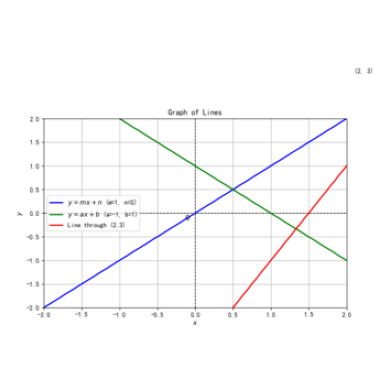

In [23]:
sample = pds[0]

print(sample["instruction"])
print()
print(sample["response"])

import matplotlib.pyplot as plt
plt.imshow(sample["image"])
plt.axis("off")


In [24]:
pip install -U transformers accelerate bitsandbytes peft


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install --force-reinstall protobuf==4.25.3


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 4.25.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires

In [26]:
import torch
from transformers import (AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig,)

In [27]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_compute_dtype = torch.float16,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_use_double_quant = True,
)
print("works")

works


In [28]:
#load the model
model = AutoModelForVision2Seq.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-instruct",
    quantization_config = bnb_config,
    device_map = "auto",
    trust_remote_code = True,
)
print("model loaded")

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

model loaded


In [29]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-instruct",
                                         trust_remote_code = True,)

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


In [30]:
print(type(model))
print(model.device)


<class 'transformers.models.qwen2_5_vl.modeling_qwen2_5_vl.Qwen2_5_VLForConditionalGeneration'>
cuda:0


In [31]:
import torch

# Take one preprocessed sample
sample = pds[0]

img = sample["image"]
ins = sample["instruction"]
response = sample["response"]

#qwen type chat message
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": ins},
        ],
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": response},
        ],
    },
]

#buidl the prompt
prompt = processor.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=False,
)

inputs = processor(
    text=prompt,
    images=img,
    return_tensors="pt",
    padding=True,
)

inputs = {k: v.to(model.device) for k, v in inputs.items()}


with torch.no_grad():
    outputs = model(**inputs)

# print("Forward pass OK")
print("Logits shape:", outputs.logits.shape)


Forward pass OK
Logits shape: torch.Size([1, 643, 151936])


In [32]:
from peft import LoraConfig, get_peft_model

lc = LoraConfig(
    r=8,
    lora_alpha = 16,
    lora_dropout = 0.05,
    target_modules = ["q_proj", "v_proj"],
    bias = "none",
    task_type = "CAUSAL_LM",
)

model = get_peft_model(model, lc)

In [33]:
model.print_trainable_parameters()

# with torch.no_grad():
#     outputs = model(**inputs)

# print("ok")


trainable params: 1,843,200 || all params: 3,756,466,176 || trainable%: 0.0491


In [34]:
def collate_fn(batch):
    images = []
    prompts = []

    for sample in batch:
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": sample["instruction"]},
                ],
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": sample["response"]},
                ],
            },
        ]

        prompt = processor.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False,
        )

        prompts.append(prompt)
        images.append(sample["image"])

    inputs = processor(
        text=prompts,
        images=images,
        return_tensors="pt",
        padding=True,
    )

 
    labels = inputs["input_ids"].clone()

    for i, prompt in enumerate(prompts):
        assistant_start = prompt.rfind("<|im_start|>assistant")
        if assistant_start == -1:
            labels[i, :] = -100
            continue

        prefix = prompt[:assistant_start]
        prefix_ids = processor.tokenizer(
            prefix,
            return_tensors="pt",
            add_special_tokens=False,
        )["input_ids"]

        labels[i, : prefix_ids.shape[1]] = -100

    inputs["labels"] = labels

    return inputs


In [35]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = "./ft_qwen_lora",
    per_device_train_batch_size = 1,
    gradient_accumulation_steps=8,
    learning_rate = 2e-4,
    num_train_epochs = 5,
    fp16 = True,
    logging_steps = 10,
    save_steps = 200,
    save_total_limit = 2,
    # evaluation_strategy = "no",
    report_to = "none",
    remove_unused_columns = False,
)

In [36]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pds,
    data_collator=collate_fn, 
)


In [37]:
batch = [pds[i] for i in range(2)]
inputs = collate_fn(batch)

inputs = {k: v.to(model.device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

print("Loss:", outputs.loss)


Loss: tensor(4.7431, device='cuda:0')


In [38]:
trainer.train()

Step,Training Loss
10,5.007700
20,4.030900
30,3.137400
40,2.681600
50,2.505500
60,2.370100
70,2.340700
80,2.287400
90,2.231800
100,2.215800


TrainOutput(global_step=315, training_loss=2.4120041650439066, metrics={'train_runtime': 2347.6167, 'train_samples_per_second': 1.065, 'train_steps_per_second': 0.134, 'total_flos': 3.123386080591872e+16, 'train_loss': 2.4120041650439066, 'epoch': 5.0})

In [39]:
model.save_pretrained("./ft_qwen_lora")
processor.save_pretrained("./ft_qwen_lora")


[]

In [40]:
import torch
from peft import PeftModel
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig

# Recreate quantization config (must match training)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

# Load base Qwen-VL model
base_model = AutoModelForVision2Seq.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

# Load LoRA adapters
model = PeftModel.from_pretrained(
    base_model,
    "./ft_qwen_lora",
)

# Load processor
processor = AutoProcessor.from_pretrained("./ft_qwen_lora")

print("Model and LoRA adapters loaded successfully")


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and LoRA adapters loaded successfully
